In [17]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from model.basic_1_22 import MultiDecoderCondVAE,integrated_loss_fn
from vae_earlystopping import EarlyStopping

DataLoader 로드 완료.
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [10/300] | Train: 6.4457 | Val: 5.6261
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
Epoch [20/300] | Train: 5.2042 | Val: 4.9749
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
Epoch [30/300] | Train: 4.4689 | Val: 3.9578
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlySt

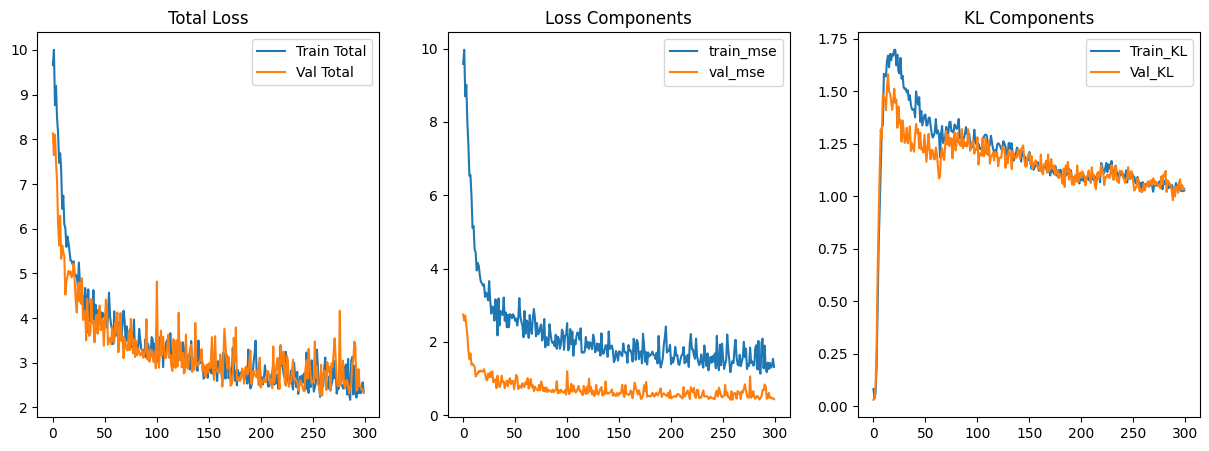

NameError: name 'accuracy_score' is not defined

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # 저장된 DataLoader를 불러옵니다.
    train_loader = torch.load('torch/train_loader.pt', weights_only=False)
    val_loader = torch.load('torch/val_loader.pt', weights_only=False)
    print("DataLoader 로드 완료.")
except FileNotFoundError:
    print("오류: 'torch/' 폴더 내에 데이터 파일이 없습니다.")
    exit()

# 2. 모델 및 최적화 설정
# 샘플을 통해 입력 차원을 자동으로 결정합니다.
x_sample, c_sample = next(iter(train_loader))
model = MultiDecoderCondVAE(x_dim=x_sample.shape[1], c_dim=c_sample.shape[1]).to(device)
early_stopping = EarlyStopping(patience = 40, min_delta=1e-9)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)

def get_beta_cyclical(epoch, total_epochs, n_cycles=4, beta_max=0.01):
    cycle_len = total_epochs // n_cycles
    relative_epoch = epoch % cycle_len
    # 각 사이클의 전반부 50% 동안만 선형적으로 증가
    beta = min(beta_max, (relative_epoch / (cycle_len * 0.5)) * beta_max)
    return beta

# 3. 학습 루프
history = {'train_total': [], 'val_total': [], 'train_mse': [], 'val_mse': [], 'train_kl': [],'val_kl':[]}
epochs = 300


for epoch in range(1, epochs + 1):
    model.train()
    t_loss, t_mse, t_kl = 0, 0, 0
    # KL Annealing: 학습 초반엔 재구성에, 후반엔 분포 학습에 집중
    beta = get_beta_cyclical(epoch,epochs)

    for x, c in train_loader:
        x, c = x.to(device), c.to(device)
        
        optimizer.zero_grad()
   
        mask_logits, prob_mask, mask_out, recon_numeric, z_mu, z_logvar = model(x, c)
        
        # 손실 함수 계산
        loss_dict = integrated_loss_fn(mask_out, recon_numeric, x,  z_mu, z_logvar, beta = 1.0)
        
        loss_dict['loss'].backward()
        optimizer.step()
        
        t_loss += loss_dict['loss'].item()
        t_mse += loss_dict['mse'].item()
        t_kl += loss_dict['kl'].item()

    # 4. 검증 (Validation)
    model.eval()
    v_loss = 0
    v_kl = 0
    v_mse = 0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for x_v, c_v in val_loader:
            x_v, c_v = x_v.to(device), c_v.to(device)
            v_mask_logits, v_prob_mask, v_mask_out, v_recon_numeric, v_mu, v_logvar= model(x_v, c_v)
            v_loss_dict = integrated_loss_fn(v_mask_out, v_recon_numeric, x_v,  v_mu, v_logvar, beta = 1.0)
            v_loss += v_loss_dict['loss'].item()
            v_kl += v_loss_dict['kl'].item()
            v_mse += v_loss_dict['mse'].item()
            y_true = x_v[:,:v_mask_out.shape[1]]
            all_preds.append(v_mask_out.cpu().numpy())
            all_trues.append(y_true.cpu().numpy())
    y_pred = np.concatenate(all_preds, axis=0).astype(int)
    y_true = np.concatenate(all_trues, axis=0).astype(int)

    y_pred = y_pred.reshape(-1)
    y_true = y_true.reshape(-1)

    # 결과 기록
    avg_train_loss = t_loss / len(train_loader)
    avg_val_loss = v_loss / len(val_loader)
    avg_kl_loss = v_kl/len(val_loader)
    
    history['train_total'].append(avg_train_loss)
    history['val_total'].append(avg_val_loss)
    history['val_mse'].append(v_mse / len(train_loader))
    history['train_mse'].append(t_mse / len(train_loader))
    history['train_kl'].append(t_kl / len(train_loader))
    history['val_kl'].append(avg_kl_loss)
    
    # scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}] | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if early_stopping(avg_val_loss, model): break

print("학습 완료.")

# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_total'], label='Train Total')
plt.plot(history['val_total'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_mse'], label='train_mse')
plt.plot(history['val_mse'], label='val_mse')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

In [ ]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 1) 환경 및 데이터 준비
x_scaler = joblib.load('./torch/x_scaler.pkl')
test_loader = torch.load('torch/test_loader.pt', weights_only=False)

early_stopping.load_best_model(model)
model.eval()

# 결과 저장을 위한 리스트
all_x_true = []      # 실제값 (Scaled)
all_x_recon = []     # 복원값 (Scaled)
all_mask_prob = []   # 존재 확률 (0~1)
all_c_condition = [] # 사용된 조건(c)

print("StandardScaler 기반 테스트 분석 및 물리적 복원 시작...")

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 추론
        # mask_logits: 존재 여부 로짓, recon_numeric: 수치 예측값
        mask_logits, prob_mask, mask_out, recon_numeric, z_mu, z_logvar = model(x_t, c_t)
        
        # 확률 및 최종 복원값 계산
        prob_mask = torch.sigmoid(mask_logits)
        # 최종 예측 = 수치 예측 * 마스크 확률 (Soft-masking)
        final_recon = recon_numeric * prob_mask
        
        all_x_true.append(x_t.cpu().numpy())
        all_x_recon.append(final_recon.cpu().numpy())
        all_mask_prob.append(prob_mask.cpu().numpy())
        all_c_condition.append(c_t.cpu().numpy())

# 2) 넘파이 배열 변환
all_x_true = np.vstack(all_x_true)
all_x_recon = np.vstack(all_x_recon)
all_mask_prob = np.vstack(all_mask_prob)

# 3) 역변환 (Inverse Transform) - 실제 물리적 스케일로 복구
# Scaler는 [samples, features] 형태를 기대합니다.
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_recon_raw = x_scaler.inverse_transform(all_x_recon)



Restored best model with loss: 2.597247
StandardScaler 기반 테스트 분석 및 물리적 복원 시작...


Restored best model with loss: 2.597247
테스트 데이터 기반 분석 및 역변환 시작...

[성능 평가 결과]
Final RMSE: 1.1643
Final R2 Score: 0.5404


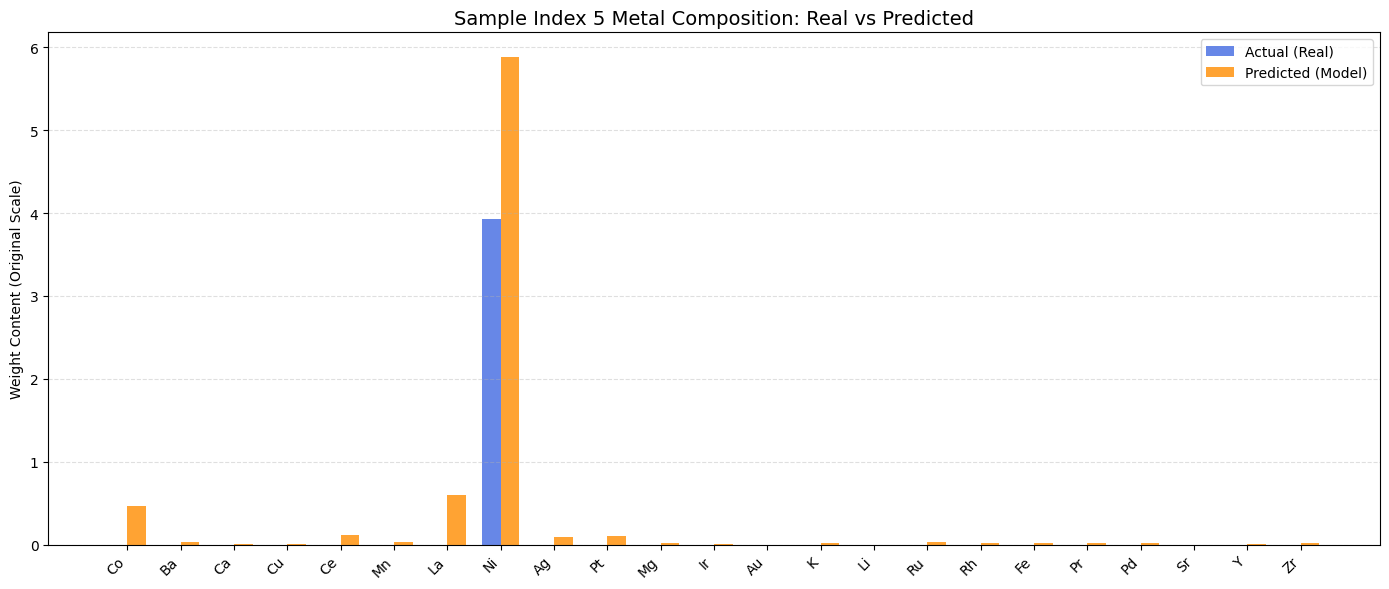

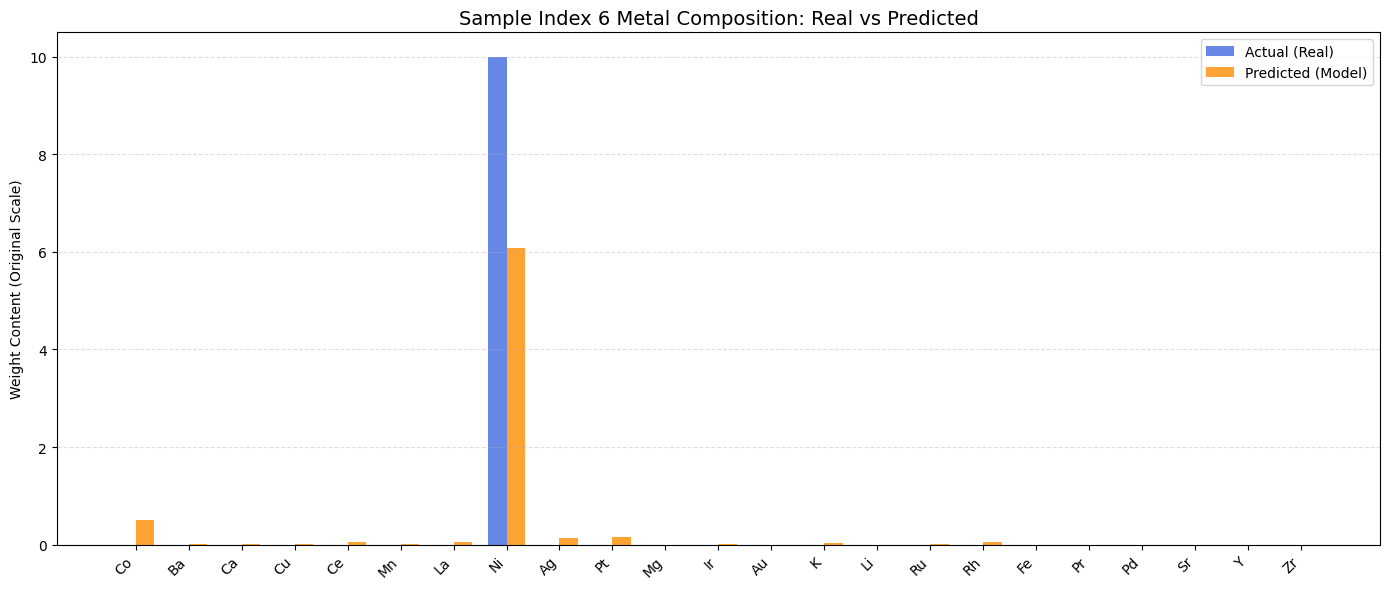

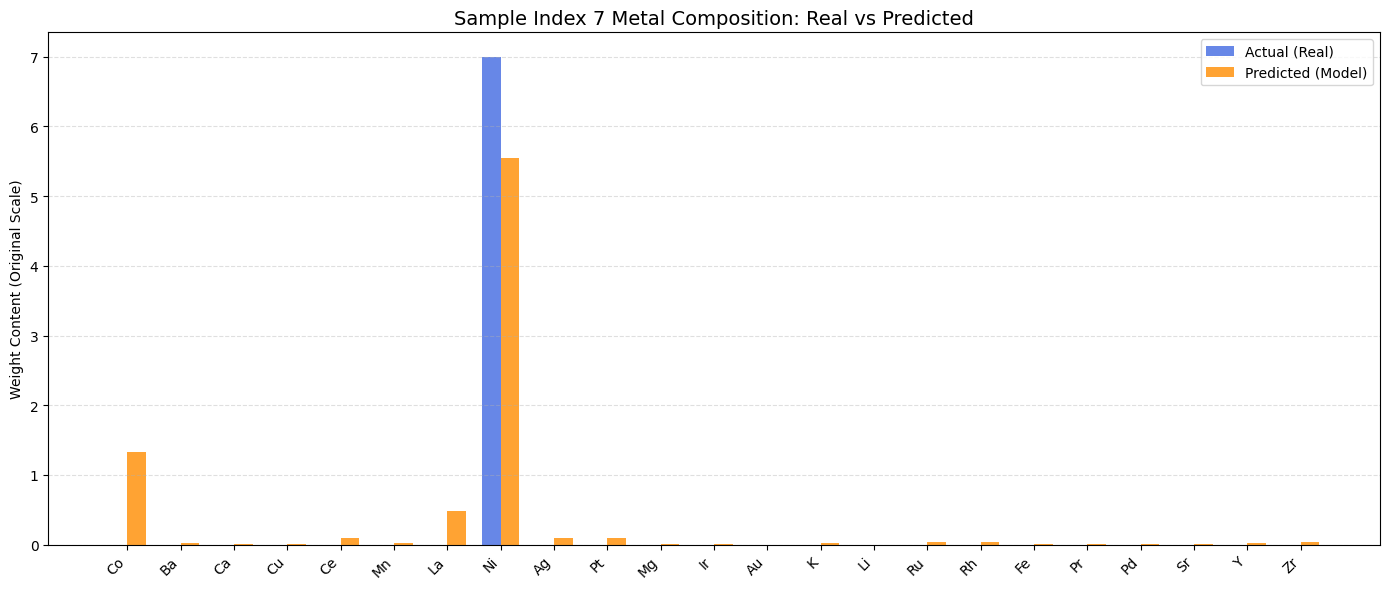

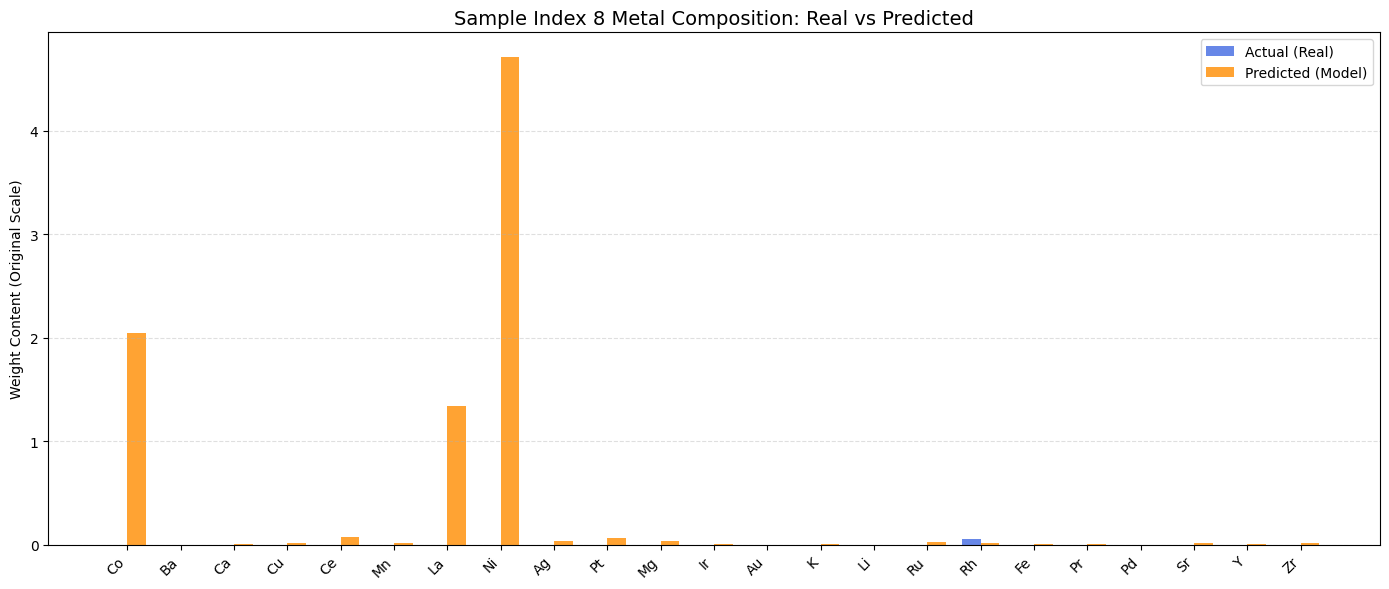

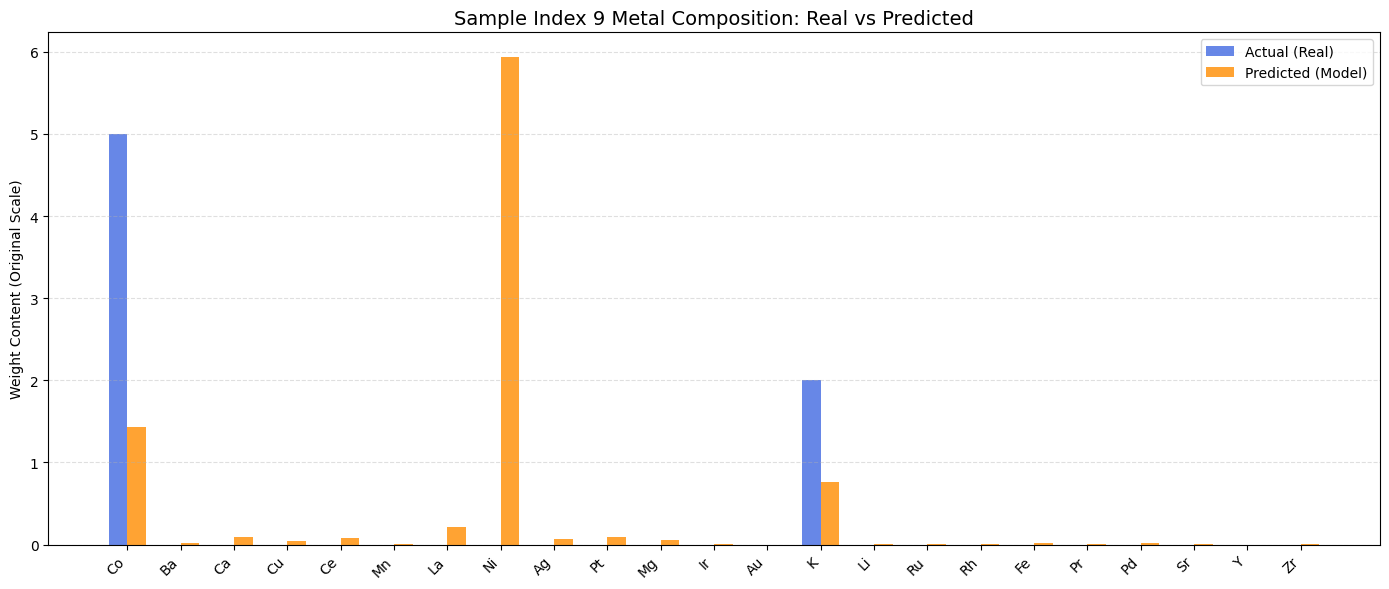

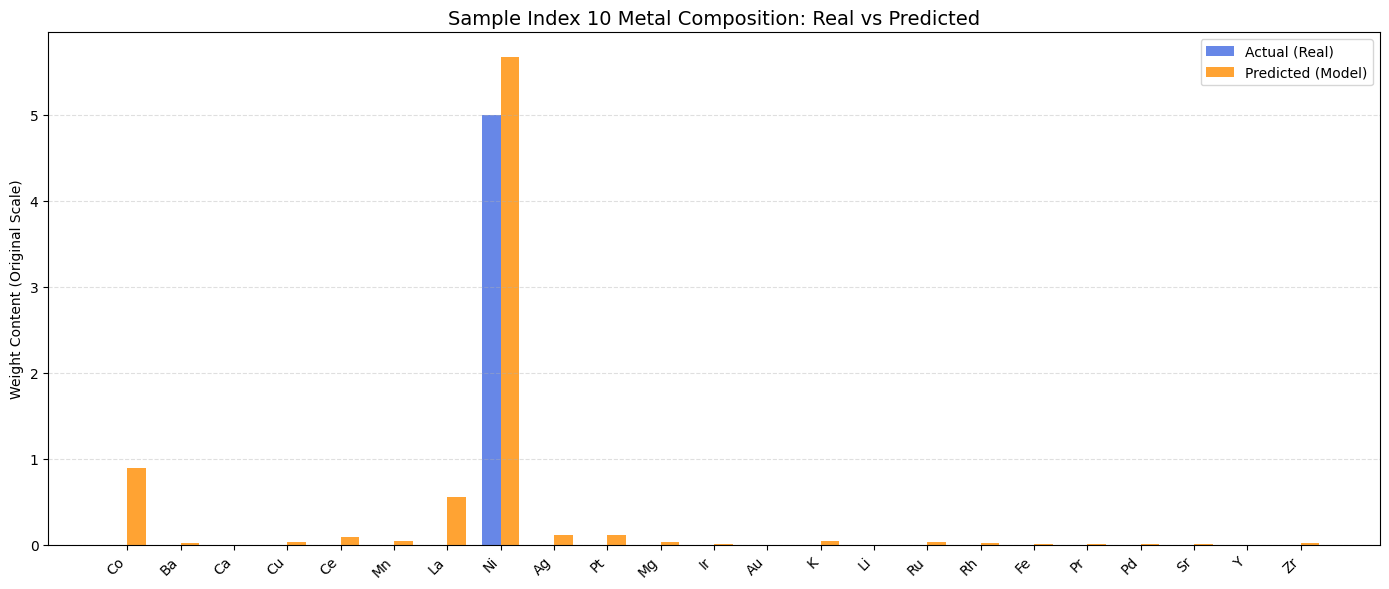

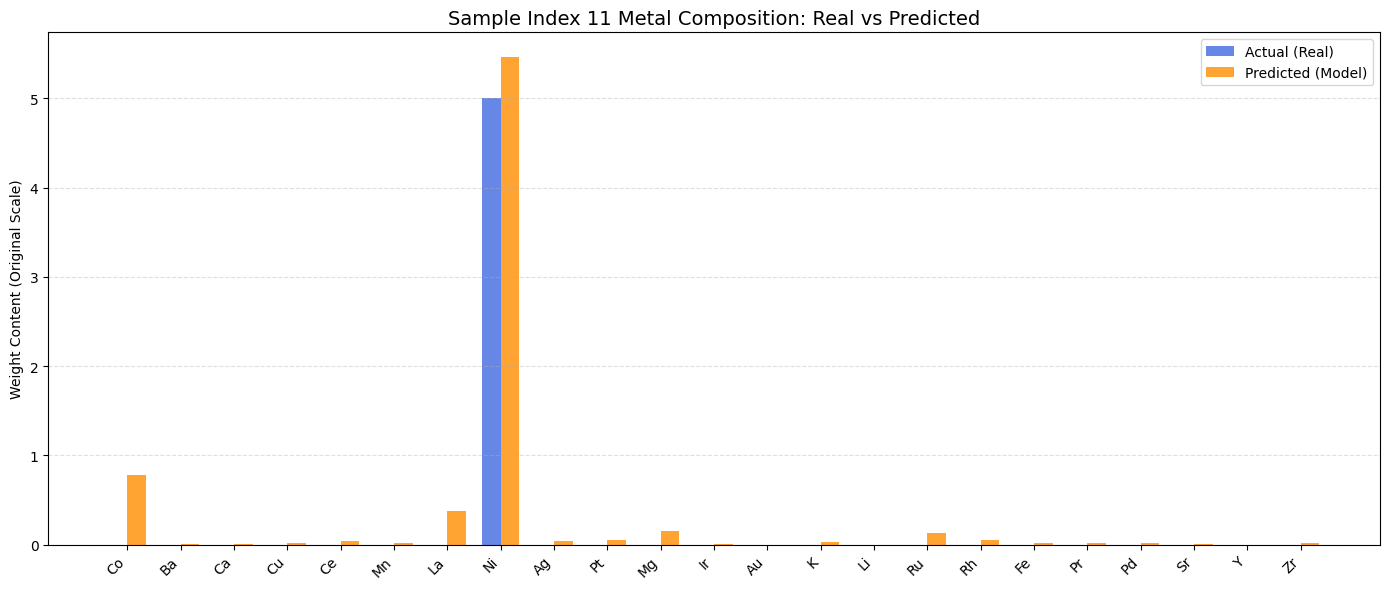

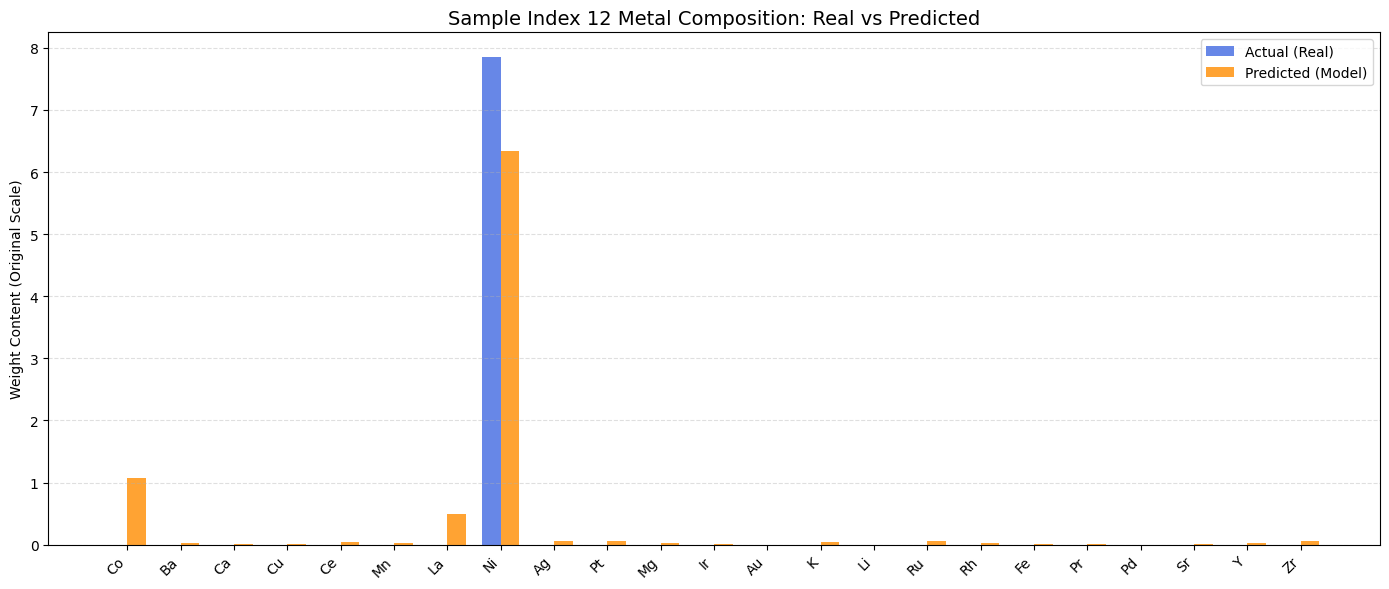

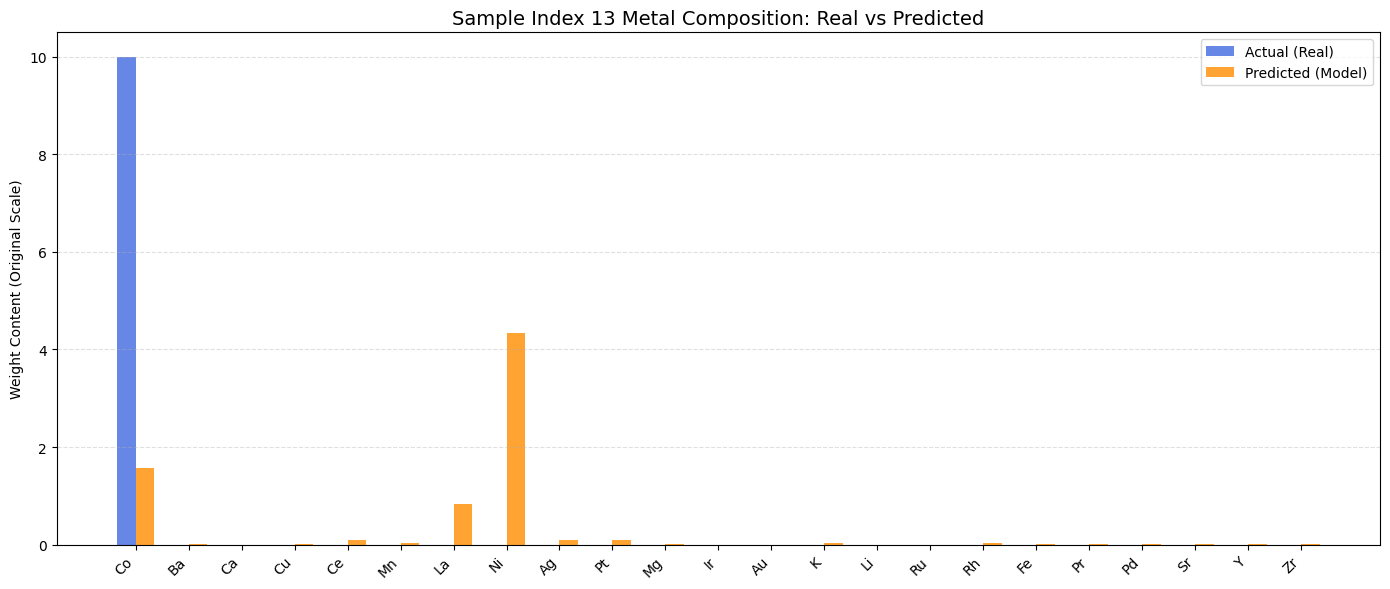

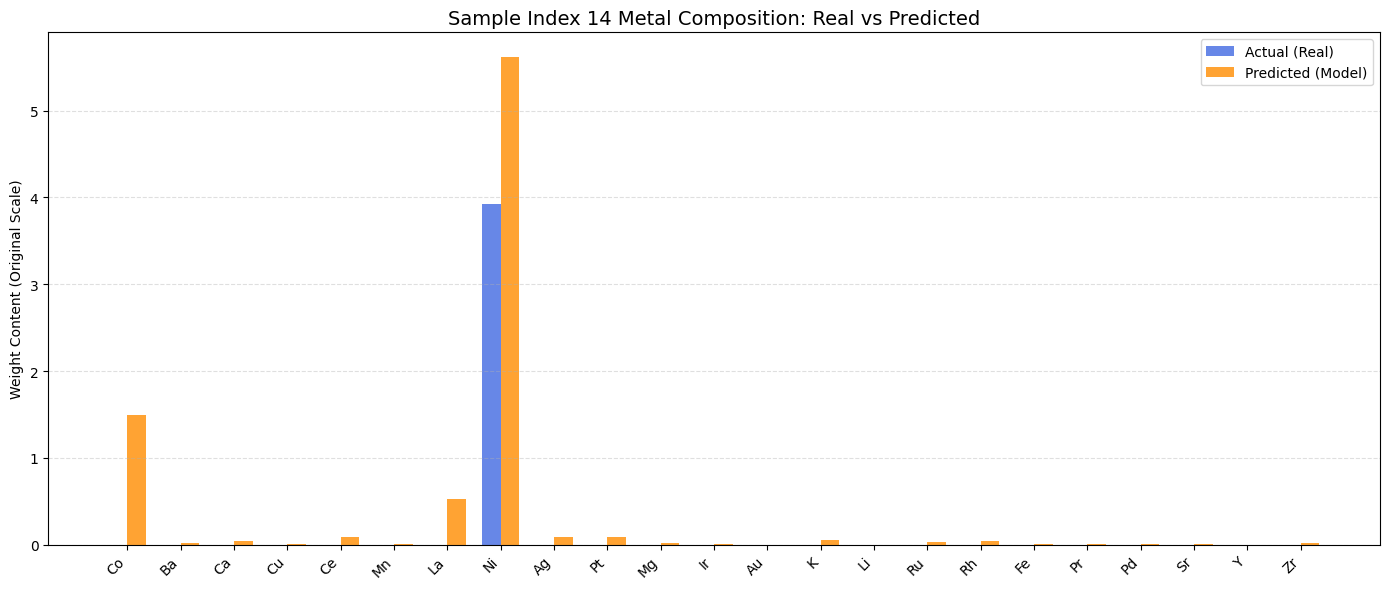

In [ ]:
import torch
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) 환경 설정 및 리소스 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 스케일러 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')

# 컬럼명 로드
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns

# 모델 평가 모드 전환
early_stopping.load_best_model(model) # EarlyStopping 객체에 저장된 최적 모델 로드
model.to(device)
model.eval()

x_true_raw_list = []
x_hat_raw_list = []

# 2) 모델 추론 및 데이터 복원
print("테스트 데이터 기반 분석 및 역변환 시작...")
with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (정의하신 MultiDecoderCondVAE 리턴 순서에 맞춤)
        # mask_logits, prob_mask, mask_out, recon_numeric, z_mu, z_logvar
        _, prob_mask, _, recon_numeric, _, _ = model(x_t, c_t)
        
        # [핵심] Hurdle 방식의 최종 예측값 계산
        # 존재 확률(prob_mask)과 예측 수치(recon_numeric)를 곱하여 
        # 존재하지 않을 확률이 높은 곳의 값을 0에 가깝게 억제합니다.
        pred_combined = (prob_mask * recon_numeric).cpu().numpy()
        
        # 3) --- 역변환 (StandardScaler Inverse) ---
        # StandardScaler는 2차원 배열을 기대하므로 그대로 넣어줍니다.
        pred_raw = x_scaler.inverse_transform(pred_combined)
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())
        
        x_true_raw_list.append(actual_raw)
        x_hat_raw_list.append(pred_raw)

# 4) 데이터 통합
x_true_test = np.concatenate(x_true_raw_list, axis=0)
x_hat_test = np.concatenate(x_hat_raw_list, axis=0)

# 5) 성능 평가
print("\n[성능 평가 결과]")
# 음수 함량 방지 (물리적으로 함량은 0 이상이어야 함)
x_hat_test = np.maximum(x_hat_test, 0)

y_true = x_true_test.flatten()
y_pred = x_hat_test.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Final RMSE: {rmse:.4f}")
print(f"Final R2 Score: {r2:.4f}")

# 6) 샘플별 시각화 (5번부터 14번 샘플까지)
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.35
    
    plt.bar(x_axis - width/2, x_true_test[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_test[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()